In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import torch
from datasets import Dataset
from transformers import GPT2Tokenizer,GPT2ForSequenceClassification,Trainer,TrainingArguments
from peft import LoraConfig,get_peft_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score

In [2]:
data = pd.read_csv("/content/all-data.csv",encoding='ISO-8859-1', names=['sentiment', 'text'])

In [3]:
data.head()

,sentiment,text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [4]:
data.shape

(4846, 2)

In [5]:
data.isna().sum()

,0
sentiment,0
text,0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4846 entries, 0 to 4845
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  4846 non-null   object
 1   text       4846 non-null   object
dtypes: object(2)
memory usage: 75.8+ KB


<Axes: xlabel='sentiment', ylabel='count'>

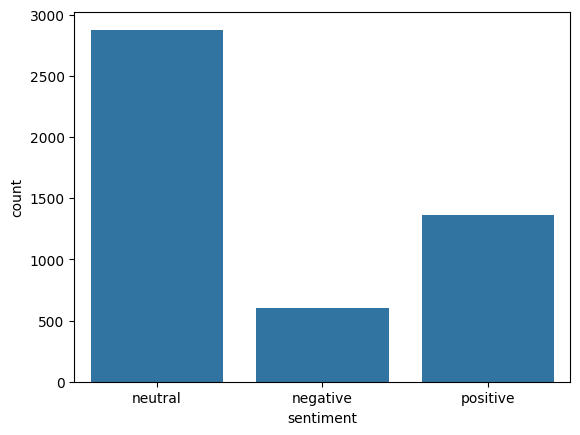

In [7]:
sns.countplot(x='sentiment',data=data)

In [8]:
label_map = {'negative':0, 'neutral':1, 'positive':2}
data['label'] = data['sentiment'].map(label_map)

In [9]:
data.head()

,sentiment,text,label
0,neutral,"According to Gran , the company has no plans t...",1
1,neutral,Technopolis plans to develop in stages an area...,1
2,negative,The international electronic industry company ...,0
3,positive,With the new production plant the company woul...,2
4,positive,According to the company 's updated strategy f...,2


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [11]:
train_data,test_data = train_test_split(data,test_size=0.2,random_state=42,stratify=data['label'])

In [12]:
train_dataset = Dataset.from_pandas(train_data[['text','label']])
test_dataset = Dataset.from_pandas(test_data[['text','label']])

print(f"Train data:{len(train_dataset)},Test data:{len(test_dataset)}")


Train data:3876,Test data:970


In [13]:
distribution = data['label'].value_counts(normalize=True)
print(distribution)

label
1    0.594098
2    0.281263
0    0.124639
Name: proportion, dtype: float64


In [14]:
model = GPT2ForSequenceClassification.from_pretrained('gpt2',num_labels= 3)
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = model.config.eos_token_id

model.to(device)

def tokenizeer(examples):
  tokenized = tokenizer(
      examples['text'],
      padding="max_length",
      truncation=True,
      max_length = 128,
      return_tensors='np'
  )

  return{
      'input_ids':np.asarray(tokenized['input_ids'],dtype=np.int64),
      'attention_mask':np.asarray(tokenized['attention_mask'],dtype=np.int64),
  }

train_dataset = train_dataset.map(tokenizeer,batched=True,remove_columns=['text'])
test_dataset = test_dataset.map(tokenizeer,batched=True,remove_columns=['text'])


train_dataset.set_format('torch',columns=['input_ids','attention_mask','label'])
test_dataset.set_format('torch',columns=['input_ids','attention_mask','label'])


print("sample :", train_dataset[0])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/3876 [00:00<?, ? examples/s]

Map:   0%|          | 0/970 [00:00<?, ? examples/s]

sample : {'label': tensor(2), 'input_ids': tensor([  464,  1688, 31247,  3220,   511,  5928,  6099,  4200,   416,   604,
           13,    20,   583,  1247,   938,   614,   837,   284, 17759,    13,
         3459,  1510, 49622,   422, 29637,    13,  5892,  1510, 49622,   287,
         5472,   764, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256,

## Fine -tuning GPT-2 with LoRa

In [15]:
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["c_attn","c_prog"],
    lora_dropout=0.1,
    bias="none",
    task_type="SEQ_CLS"
)

model = get_peft_model(model,lora_config)
model.print_trainable_parameters()

def metrics_fn(pred):
  labels = np.asarray(pred.label_ids)
  preds = np.asarray(pred.predictions.argmax(-1))
  accuracy = accuracy_score(labels,preds)
  f1 = f1_score(labels,preds,average='weighted')
  return {"accuracy":accuracy,"f1":f1}


training_args = TrainingArguments(
    output_dir="./financial-gpt-2",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to="none"


)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=metrics_fn
)

trainer.train()

/usr/local/lib/python3.11/dist-packages/peft/tuners/lora/layer.py:1768: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


trainable params: 297,216 || all params: 124,739,328 || trainable%: 0.2383


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.019700,0.881533,0.617526,0.548770
2,0.823900,0.824699,0.652577,0.594486
3,0.876600,0.813659,0.654639,0.607037


TrainOutput(global_step=1455, training_loss=0.9615116856761814, metrics={'train_runtime': 237.915, 'train_samples_per_second': 48.875, 'train_steps_per_second': 6.116, 'total_flos': 762250741678080.0, 'train_loss': 0.9615116856761814, 'epoch': 3.0})

## Eval and Inference

In [16]:

results = trainer.evaluate()
print(f"Test Accuracy: {results['eval_accuracy']:.4f}")
print(f"Test F1-Score: {results['eval_f1']:.4f}")


def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).item()
    return {0: "negative", 1: "neutral", 2: "positive"}[predicted_class]


sample_text = "The company's stock surged after strong Q2 earnings."
print(f"Sample prediction: {predict_sentiment(sample_text)}")

Test Accuracy: 0.6546
Test F1-Score: 0.6070
Sample prediction: positive


In [18]:
# Save model and tokenizer
model.save_pretrained("./gpt2-financial-sentiment-final")
tokenizer.save_pretrained("./gpt2-financial-sentiment-final")

# Optional: Push to Hugging Face Hub
from huggingface_hub import notebook_login
notebook_login()
model.push_to_hub("Seniyax/gpt2-financial-sentiment")
tokenizer.push_to_hub("Seniyax/gpt2-financial-sentiment")

Uploading...:   0%|          | 0.00/1.19M [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Seniyax/gpt2-financial-sentiment/commit/0bfa8340c358a13c1621c5c9a32195ca1ed3819a', commit_message='Upload tokenizer', commit_description='', oid='0bfa8340c358a13c1621c5c9a32195ca1ed3819a', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Seniyax/gpt2-financial-sentiment', endpoint='https://huggingface.co', repo_type='model', repo_id='Seniyax/gpt2-financial-sentiment'), pr_revision=None, pr_num=None)